# Tester notebook for RCC

In [1]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
from tqdm import tqdm
import pandas as pd

#from clustering import *
from radially_constrained_cluster import *

In [2]:
italy_region = gpd.read_file('/work/users/jgrassi/data/italy.shp')

def plot_map(geo_df, column_to_color, cmap, vmin, vmax, title):

    # Defining the figure
    fig, ax = plt.subplots(1,1, figsize=(6,6)) 

    
    # Plot the map
    cax = geo_df.plot(column=column_to_color, cmap=cmap, ax=ax, legend=False, vmin=vmin, vmax=vmax)

    # Adding regional boundaries
    italy_region.boundary.plot(color = 'k', linewidth = 0.5, label = 'Regioni', ax=ax)

    # Customize the axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')
    ax.grid(alpha=0.3)

    # Creating a custom colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax)

    ax.set_title(title)

    return ax, fig, cbar

In [3]:
data_path = '/work/users/jgrassi/data/ERA5'

data_obj = []

for files in ['2m_temperature/temperature_19*.nc', 'total_precipitation/precipitation_19*.nc']:

    obj = xr.open_mfdataset(rf'{data_path}/{files}')
    obj = obj.convert_calendar('noleap').rolling(time=15*24, center=True).mean().load()

    obj.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    obj.rio.write_crs("epsg:4326", inplace=True)

    data_obj.append(obj)

  0%|          | 0/20 [00:00<?, ?it/s]

(365, 238)


  5%|▌         | 1/20 [00:32<10:15, 32.41s/it]

(365, 406)


 10%|█         | 2/20 [01:03<09:32, 31.79s/it]

(365, 252)


 15%|█▌        | 3/20 [01:29<08:13, 29.04s/it]

(365, 350)


 20%|██        | 4/20 [01:58<07:42, 28.88s/it]

(365, 336)


 25%|██▌       | 5/20 [02:26<07:10, 28.68s/it]

(365, 546)


 30%|███       | 6/20 [03:01<07:09, 30.68s/it]

(365, 196)


 35%|███▌      | 7/20 [03:25<06:11, 28.59s/it]

(365, 434)


 40%|████      | 8/20 [03:54<05:44, 28.67s/it]

(365, 140)


 45%|████▌     | 9/20 [04:14<04:47, 26.13s/it]

(365, 644)


 50%|█████     | 10/20 [04:50<04:52, 29.21s/it]

(365, 238)


 55%|█████▌    | 11/20 [05:15<04:10, 27.87s/it]

(365, 126)


 60%|██████    | 12/20 [05:37<03:28, 26.06s/it]

(365, 602)


 65%|██████▌   | 13/20 [06:12<03:20, 28.60s/it]

(365, 588)


 70%|███████   | 14/20 [06:47<03:03, 30.58s/it]

(365, 616)


 75%|███████▌  | 15/20 [07:24<02:43, 32.69s/it]

(365, 574)


 80%|████████  | 16/20 [07:57<02:10, 32.68s/it]

(365, 364)


 85%|████████▌ | 17/20 [08:24<01:32, 30.94s/it]

(365, 210)


 90%|█████████ | 18/20 [08:46<00:56, 28.37s/it]

(365, 70)


 95%|█████████▌| 19/20 [09:05<00:25, 25.49s/it]

(365, 462)


100%|██████████| 20/20 [09:36<00:00, 28.85s/it]


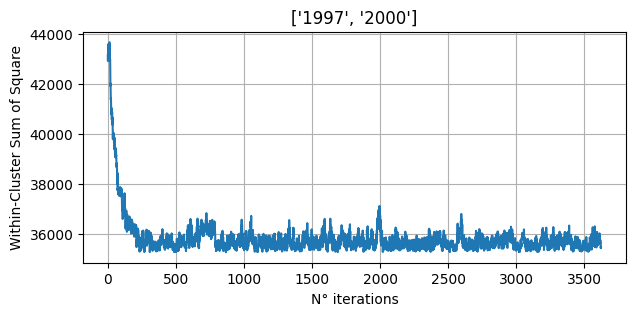

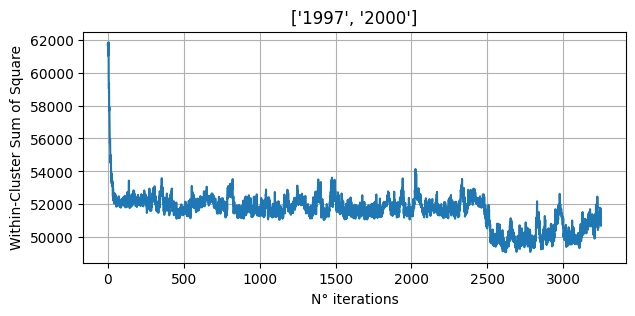

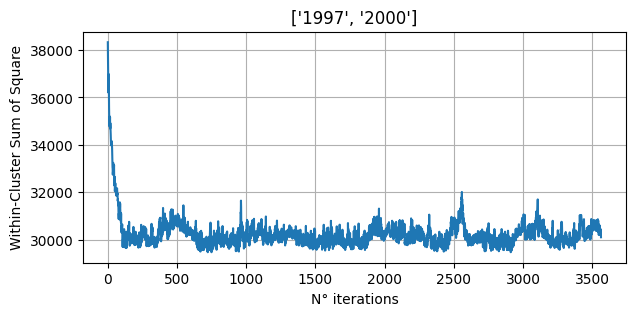

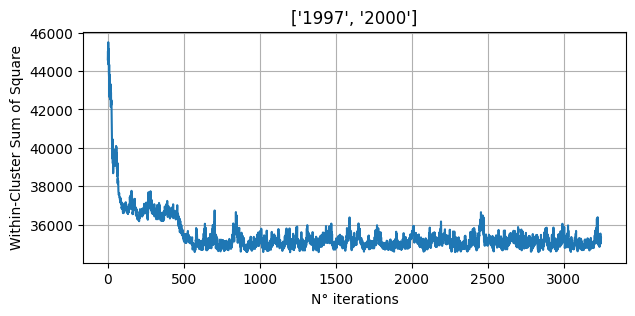

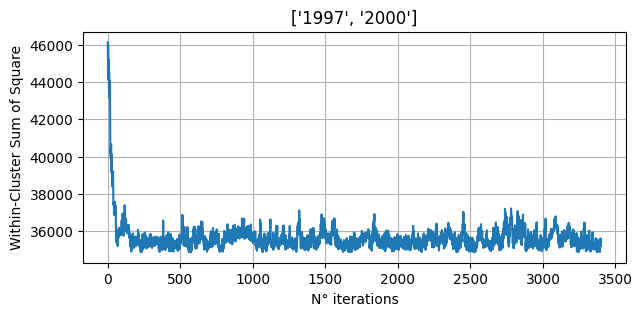

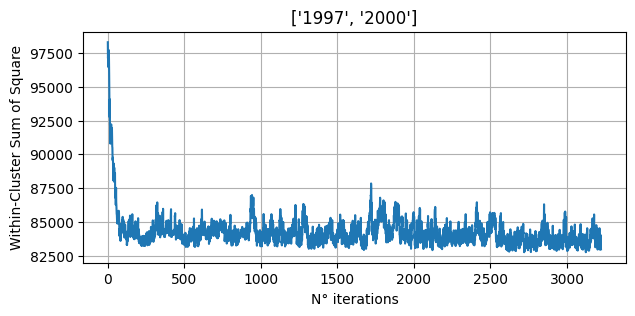

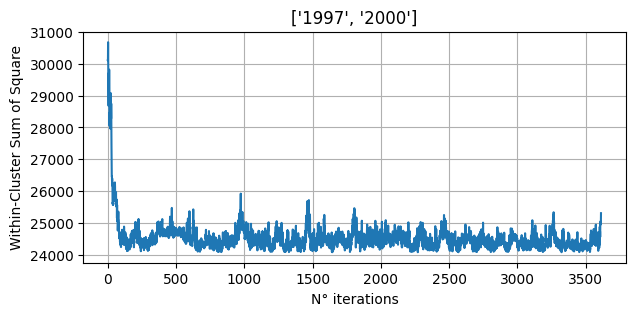

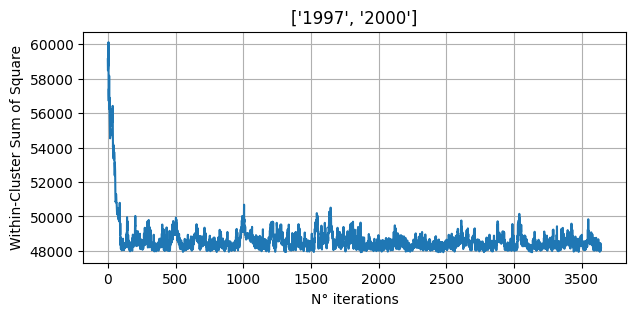

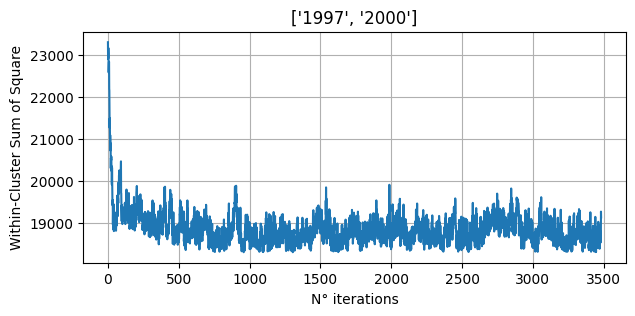

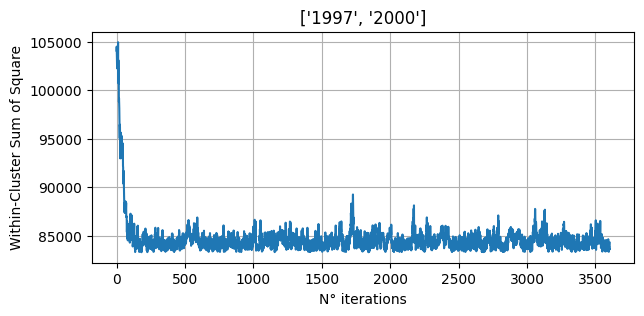

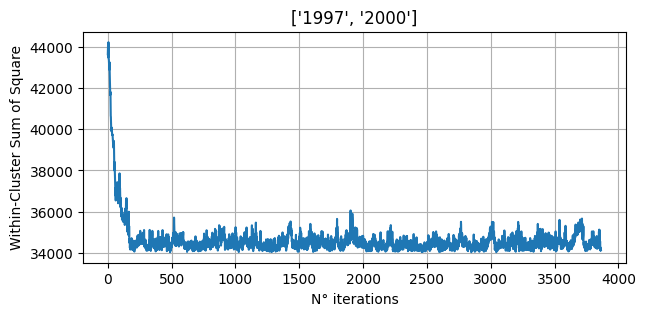

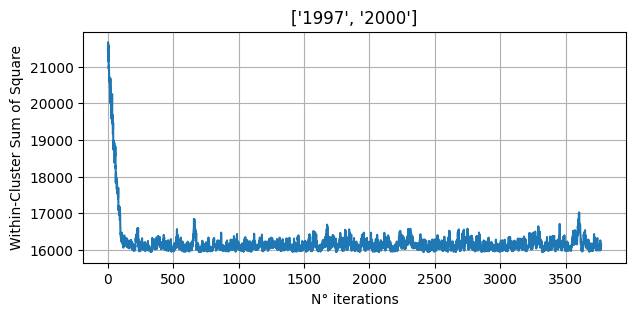

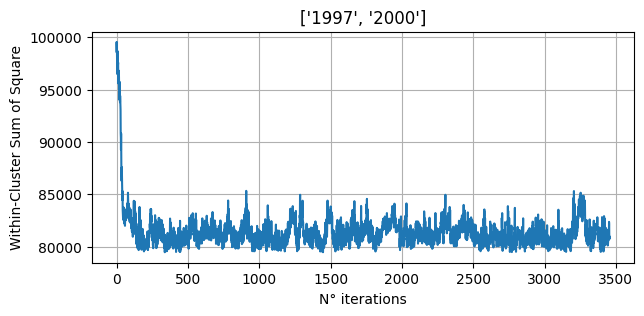

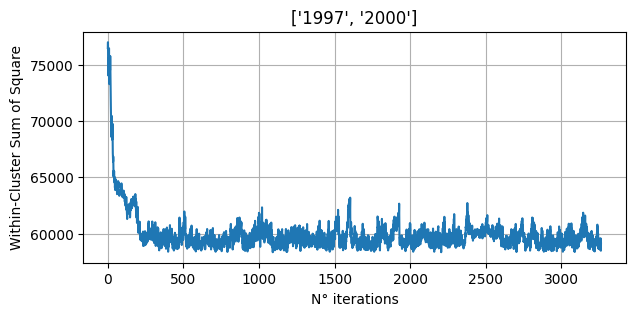

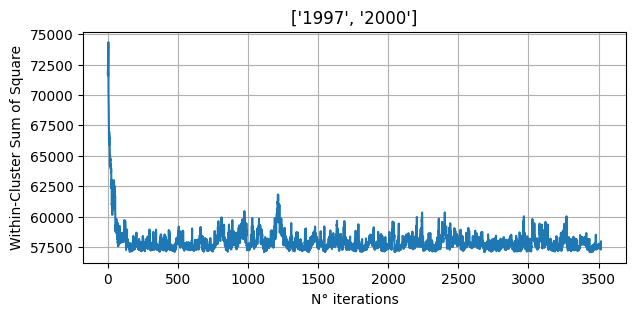

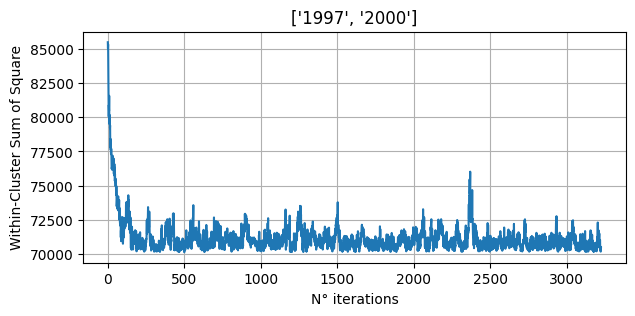

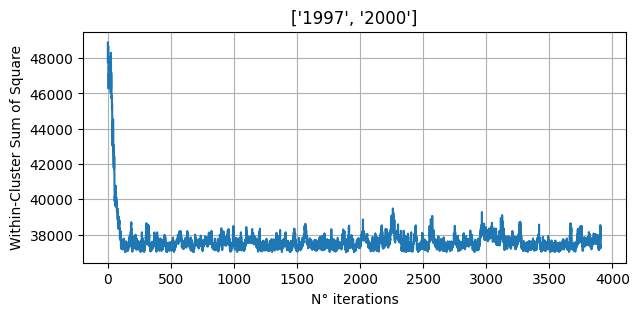

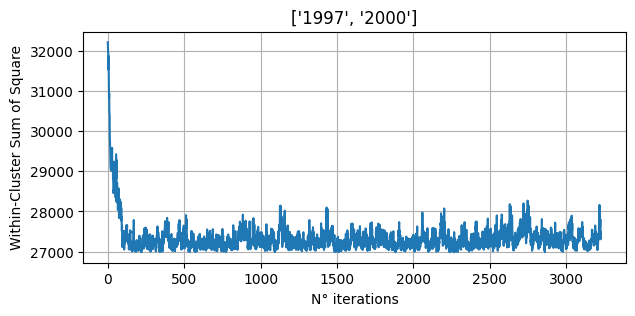

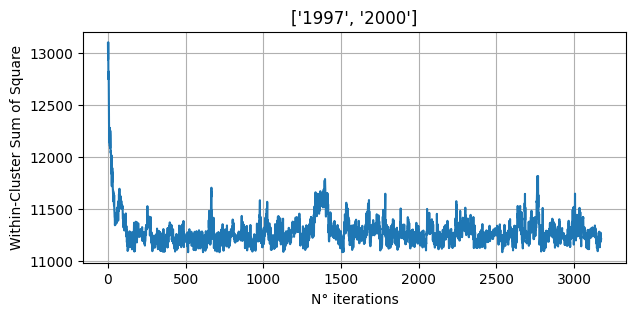

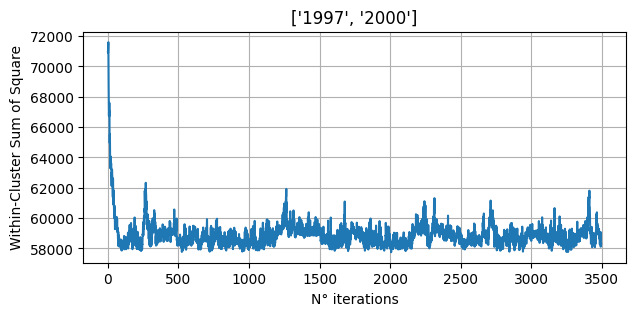

In [4]:
italy_region = gpd.read_file('/work/users/jgrassi/data/italy.shp')


# periods = [['1979','1982'],['1982','1985'],['1985','1988'],['1988','1991'],['1991','1994'],['1994','1997'],['1997','2000'],['2000','2003'],['2003','2006'],['2006','2009']]ù
periods = [['1979','1982'],['1982','1985'],['1985','1988'],['1988','1991'],['1991','1994'],['1994','1997'],['1997','2000']]

bp_macro = []
tot = []
all_arrays = []

for j in tqdm(range(20)):

    gpp = italy_region.loc[j]
    new = gpd.GeoDataFrame(gpp)
    new.columns = ['geometry']
    gdf = new.set_geometry('geometry')


    arrays = []

    for obj, var in zip(data_obj, ['t2m','tp','sfcWind']):

        for p in periods:

            obj_rast = obj.sel(time=slice(p[0], p[1]))
            obj_rast = obj_rast.groupby('time.dayofyear').mean()
            obj_rast = obj_rast.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

            obj_array = obj_rast[var].to_numpy()
            obj_array = np.reshape(obj_array, (365, obj_array.shape[1]*obj_array.shape[2]))
            obj_array = obj_array[:,~np.all(np.isnan(obj_array), axis=0)]
            #obj_array = (obj_array - obj_array.min(axis=0)) / (obj_array.max(axis=0) - obj_array.min(axis=0))
            obj_array = (obj_array - obj_array.mean(axis=0)) / (obj_array.std(axis=0))
            arrays.append(obj_array)



    # concatenate the two arrays on columns
    array_tot = np.concatenate((arrays), axis=1)
    
    #array_tot = array_tot[:,~np.all(np.isnan(array_tot), axis=0)]
    print(array_tot.shape)

    # min-max normalization on axis 1
    #array_tot = (array_tot - array_tot.min(axis=1).reshape(-1, 1)) / (array_tot.max(axis=1) - array_tot.min(axis=1)).reshape(-1, 1)


    model = Radially_Constrained_Cluster(data_to_cluster = array_tot,
                                     n_seas = 4,
                                     n_iter = 5000,
                                     learning_rate = 2,
                                     min_len = 60,
                                     scheduling_factor = 1,
                                     starting_bp = [60, 152, 244, 335],
                                     mode = 'single')

    model.fit()

    fig_learning = plt.figure(figsize = (7,3))
    plt.plot(model.error_history)
    plt.grid()
    plt.title(p)
    plt.xlabel('N° iterations')
    plt.ylabel('Within-Cluster Sum of Square')

    gdf['spring_onset'] = model.breakpoints[0]
    gdf['summer_onset'] = model.breakpoints[1]
    gdf['autumn_onset'] = model.breakpoints[2]
    gdf['winter_onset'] = model.breakpoints[3]

    gdf['spring_lenght'] = model.breakpoints[1] -model.breakpoints[0]
    gdf['summer_lenght'] = model.breakpoints[2] -model.breakpoints[1]
    gdf['autumn_lenght'] = model.breakpoints[3] -model.breakpoints[2]
    gdf['winter_lenght'] = 365 - model.breakpoints[3] + model.breakpoints[0]

    tot.append(gdf)
    all_arrays.append(array_tot)

tot = pd.concat(tot)

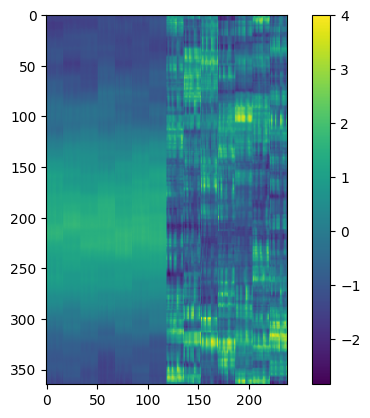

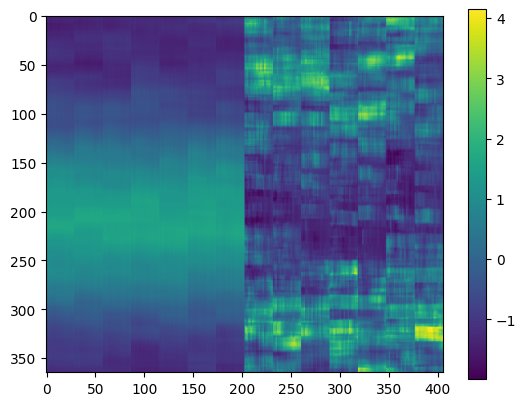

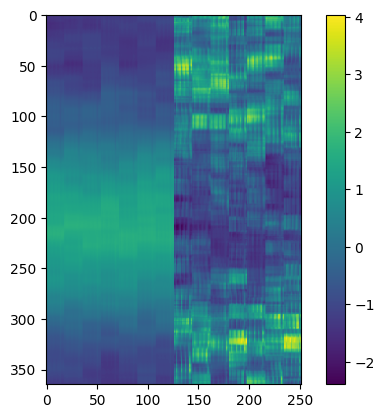

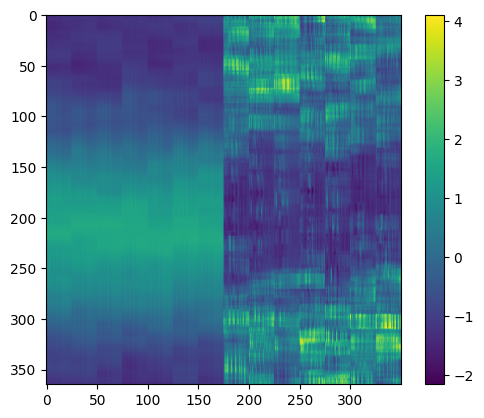

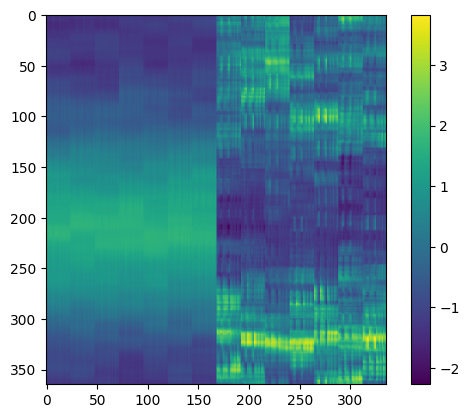

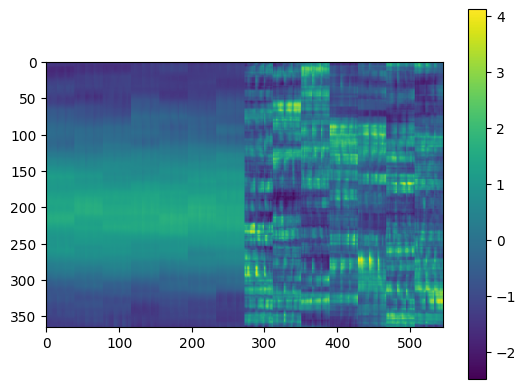

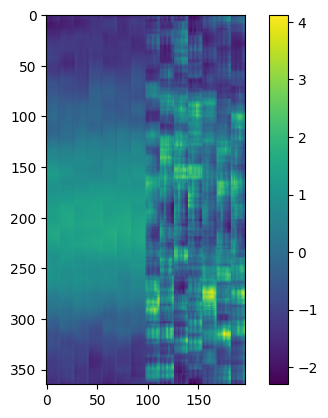

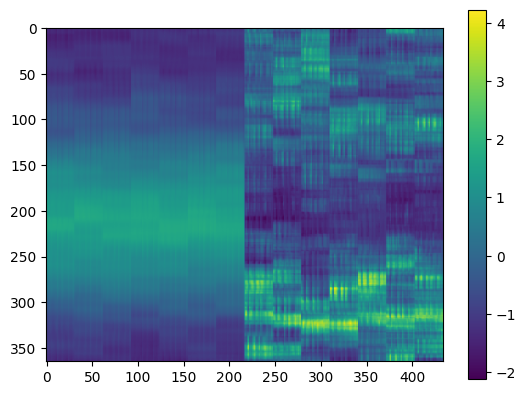

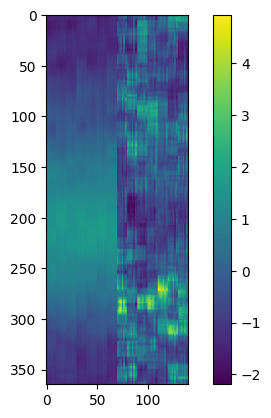

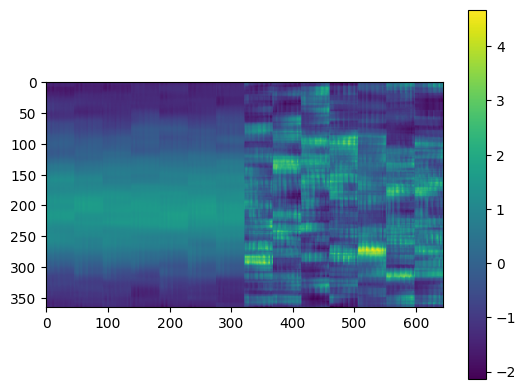

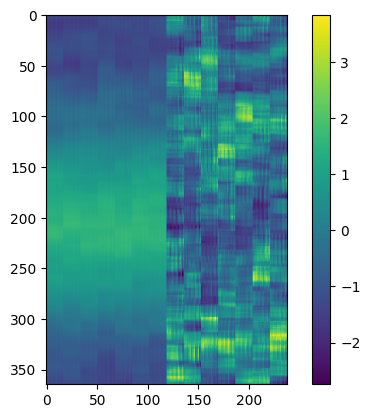

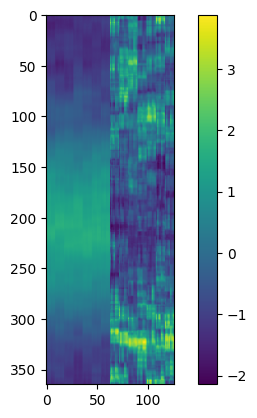

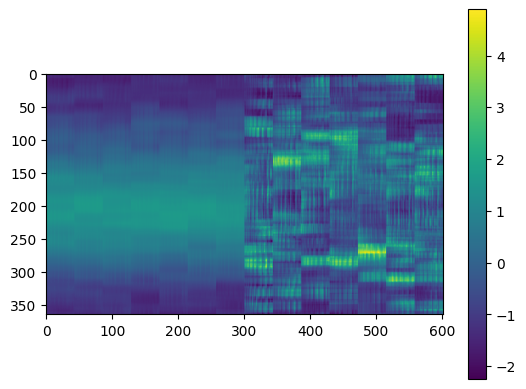

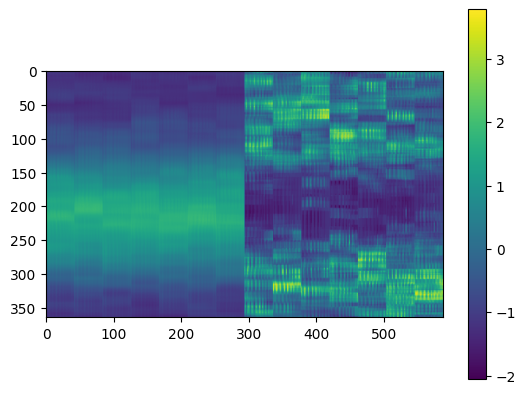

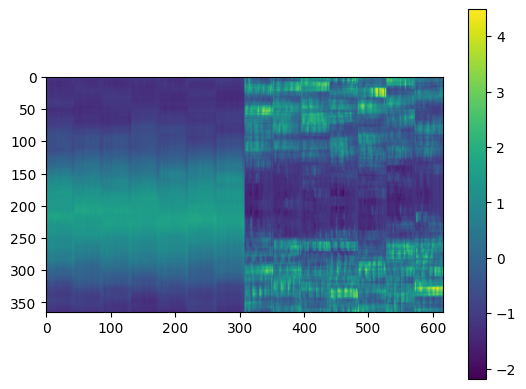

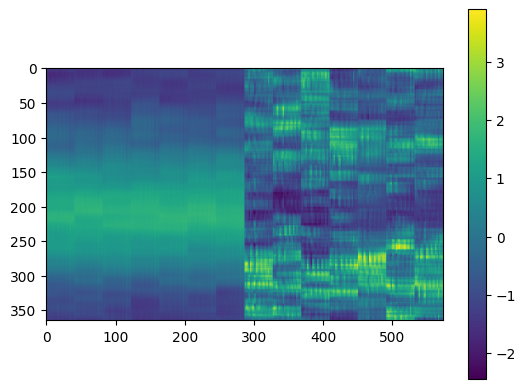

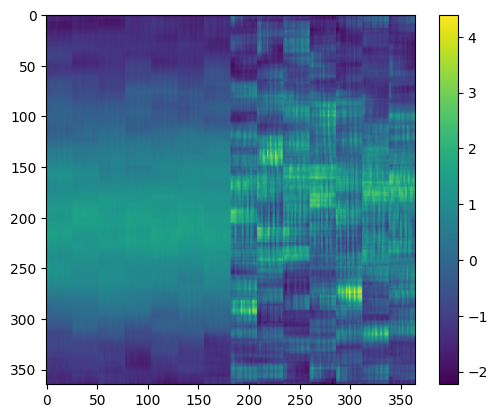

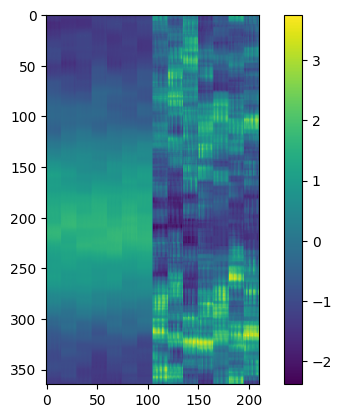

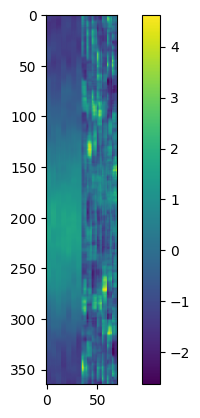

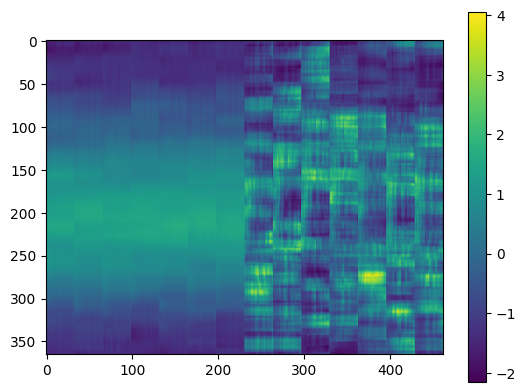

In [5]:
for t in all_arrays:
    plt.figure()
    plt.imshow(t)
    plt.colorbar()

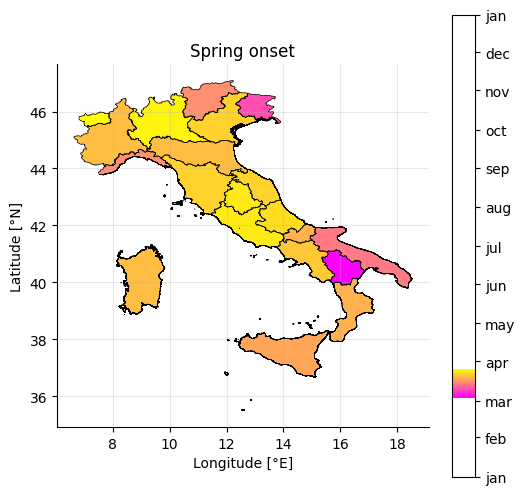

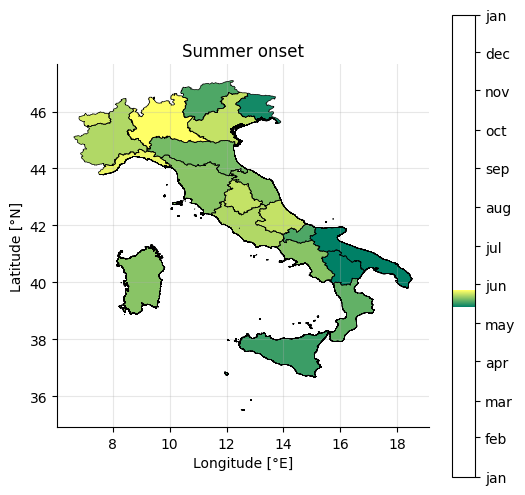

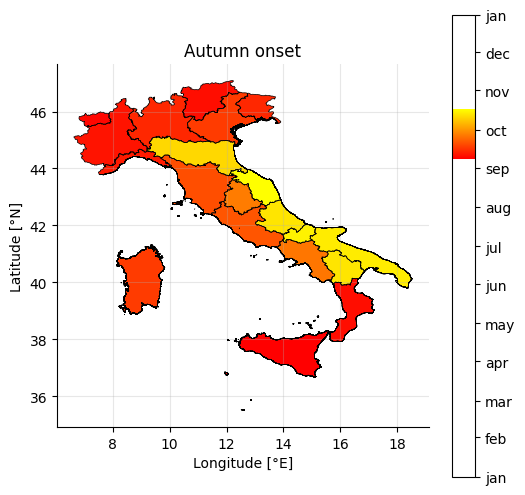

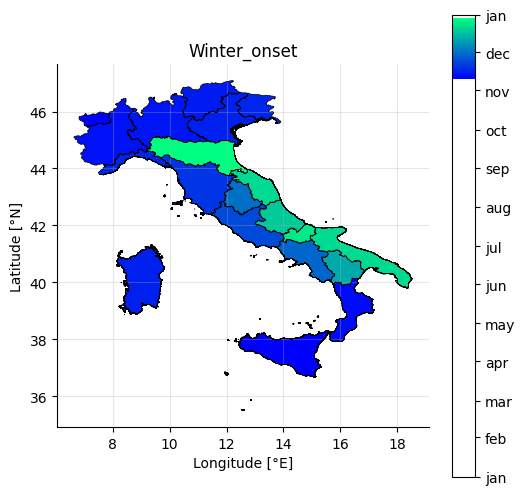

In [6]:
for onset, title, cmap in zip(['spring_onset','summer_onset','autumn_onset','winter_onset'],
                            ['Spring onset','Summer onset','Autumn onset','Winter_onset'],
                            ['spring', 'summer','autumn','winter']):
    
    fig, ax, cbar = plot_map(tot, onset, cmap, tot[onset].min(), tot[onset].max(), title)
    cbar.set_ticks(ticks=[0,31,60,91,121,152,182,213,244,274,305,335, 365],labels=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])



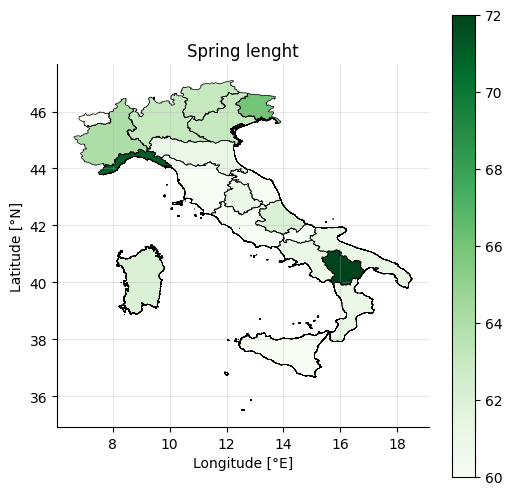

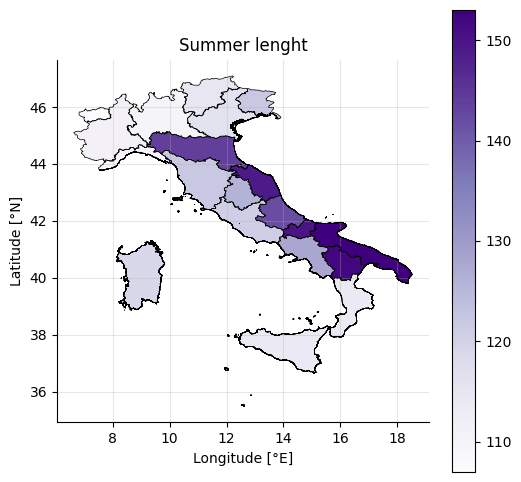

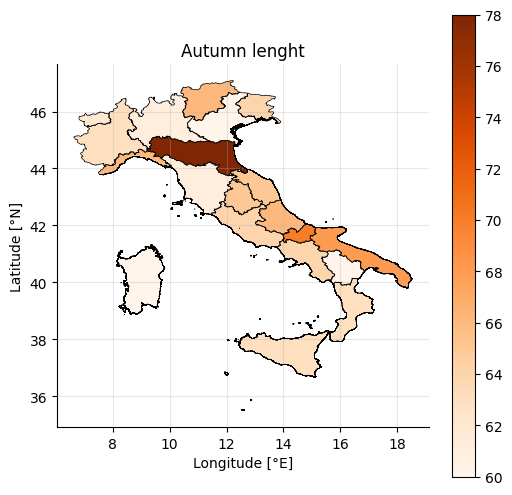

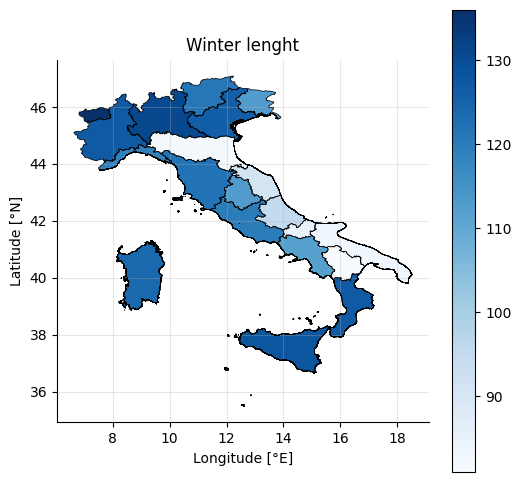

In [7]:
for lenght, title, cmap in zip(['spring_lenght','summer_lenght','autumn_lenght','winter_lenght'],
                            ['Spring lenght','Summer lenght','Autumn lenght','Winter lenght'],
                            ['Greens', 'Purples','Oranges','Blues']):
    
    fig, ax, cbar = plot_map(tot, lenght, cmap, tot[lenght].min(), tot[lenght].max(), title)


In [8]:
tot

geometry  spring_onset  \
geometry  POLYGON ((14.28018 41.91049, 14.27131 41.90198...            82   
geometry  MULTIPOLYGON (((18.39375 39.86014, 18.39319 39...            73   
geometry  MULTIPOLYGON (((16.10554 39.90751, 16.10519 39...            62   
geometry  MULTIPOLYGON (((16.12486 37.99847, 16.12486 37...            78   
geometry  MULTIPOLYGON (((15.44597 40.01931, 15.44597 40...            80   
geometry  MULTIPOLYGON (((12.50403 44.11514, 12.50403 44...            79   
geometry  MULTIPOLYGON (((13.72181 45.59681, 13.72153 45...            69   
geometry  MULTIPOLYGON (((13.45764 40.79125, 13.45792 40...            83   
geometry  MULTIPOLYGON (((7.69958 43.79792, 7.69931 43.7...            75   
geometry  MULTIPOLYGON (((9.29867 44.75333, 9.2991 44.75...            84   
geometry  POLYGON ((13.50491 42.75817, 13.50555 42.74935...            81   
geometry  POLYGON ((14.58975 41.37563, 14.58982 41.37606...            78   
geometry  POLYGON ((7.34462 44.14592, 7.33342 44.14509, ...            79   
geometry  MULTIPOLYGON (((9.00347 38.98459, 9.00236 38.9...            79   
geometry  MULTIPOLYGON (((12.54319 35.52875, 12.54347 35...            77   
geometry  MULTIPOLYGON (((11.11181 42.26209, 11.11181 42...            81   
geometry  POLYGON ((10.94552 45.67497, 10.94401 45.67402...            75   
geometry  MULTIPOLYGON (((12.45237 42.39719, 12.45205 42...            83   
geometry  POLYGON ((7.05384 45.49998, 7.04399 45.5008, 7...            85   
geometry  MULTIPOLYGON (((11.61637 44.88903, 11.61564 44...            81   

          summer_onset  autumn_onset  winter_onset  spring_lenght  \
geometry           144           286           352             62   
geometry           134           287           355             61   
geometry           134           286           346             72   
geometry           139           253           316             61   
geometry           141           269           333             61   
geometry           140           284           362             61   
geometry           135           257           321             66   
geometry           143           264           328             60   
geometry           146           255           321             71   
geometry           147           257           318             63   
geometry           141           290           355             60   
geometry           138           288           358             60   
geometry           143           254           317             64   
geometry           141           260           320             62   
geometry           137           251           314             60   
geometry           141           263           324             60   
geometry           138           253           319             63   
geometry           144           270           335             61   
geometry           145           252           314             60   
geometry           144           260           320             63   

          summer_lenght  autumn_lenght  winter_lenght  
geometry            142             66             95  
geometry            153             68             83  
geometry            152             60             81  
geometry            114             63            127  
geometry            128             64            112  
geometry            144             78             82  
geometry            122             64            113  
geometry            121             64            120  
geometry            109             66            119  
geometry            110             61            131  
geometry            149             65             91  
geometry            150             70             85  
geometry            111             63            127  
geometry            119             60            124  
geometry            114             63            128  
geometry            122             61            122  
geometry            115        